# European Call Options

In [21]:
p = 0.2 # probability of success, assumed to be unknown

### Amplitude Estimation

Defining Bernouli Circuit A and Q

    - Circuit A is defined to get a Bernouli random variable
    - Circuit Q is defined to a apply the Grover operator.
        - Grover operator is the actual estimation   part of it. Basically gets the best possible outcome based on amplitude. 
    

### How European Call Options work

Classical implementation gets the difference between strike price and spot price if it is positive as the payoff. 

Quantum Algo does the same but quantum.

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

qiskit.utils.algorithm_globals.random_seed = 2

### Log-normal random distribution into quantum state

Look at qiskit implementation on their website for [Log Normal Distribution](https://qiskit.org/documentation/stable/0.25/stubs/qiskit.circuit.library.LogNormalDistribution.html). More text is supported from this [article](https://qiskit.org/documentation/stable/0.25/stubs/qiskit.circuit.library.LogNormalDistribution.html), really good it highlights how they actually got the expression.

In the presentation I can talk about this stuff.

In [19]:
#uncertainty qubits
uncertainty_qubits = 3

#parameters for distribution, WILL CHANGE FOR SITUATION
S = 1000 # initial spot price
vol = 0.2 # volatility of 40%
r = 0.04 # annual interest rate of 4%
T = 30 / 365 # 40 days to maturity  

# parameters for how we are modeling the distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu+sigma**2)
stddev = np.sqrt(variance)

#lowest and highest value considered for spot price
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

#This contructs an operator that will be used for Quantum Amplitude Estimation
#This is essentially the circuit A I talked about earlier.
uncertainty_model = LogNormalDistribution(
    uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high), 
)


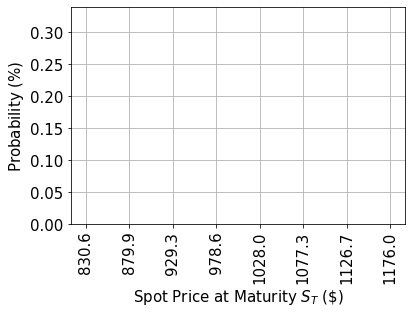

In [20]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

### Quantum Version of Payoff Function

The way this works is if the Spot Price is less than the Strike Price than it will flip an ancilla qubit, a qubit that stores previous information, from $\big|0\rangle$ to $\big|1\rangle$. 

#### Finding the linear part of the payoff function

Using the fact that $ \sin^2(y + \pi/4) \approx y + 1/2 $ for very small numbers (0-1), so we can create some approximation factor, c, and x. So, $ \sin^2( \pi/2 * c_\text{approx} * ( x - 1/2 ) + \pi/4) \approx \pi/2 * c_\text{approx} * ( x - 1/2 ) + 1/2 $ . 

The equivalent operator can then be constructed to 
$$ \big|x\rangle \big|0\rangle \mapsto \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right) $$

The $\big|1\rangle$ is what we are interested in measuring, corresponding to $$ \sin^2 (a*x+b) $$

The smaller the c value, the better the approximation.

### Creating the Circuit

In [21]:
strike_price = 1020

c_value = 0.25

breakpoints = [low, strike_price] # the range
slopes = [0,1] # different slopes of the piecewise function
offsets = [0,0] #y-intercepts of the piecewise function
f_min = 0
f_max = high - strike_price
# Linear Amplitude Function implements a circuit a piecewise linear 
# function on qubit amplitudes
european_call_objective = LinearAmplitudeFunction(
    uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_value,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))
european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

The circuit above is the circuit to evaluate the expected payoff.

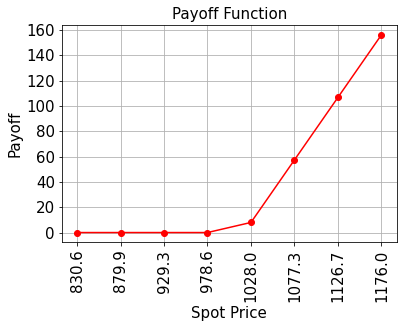

In [22]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [23]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	15.4376
exact delta value:   	0.4871


### Using the circuit to evaluate payoff

In [24]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_value,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [25]:
epsilon = 0.01 #target precision
alpha = 0.001   #confidence level

problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	15.4376
Estimated value:    	16.9376
Confidence interval:	[15.0731, 18.8022]
